### Generating seasonal statistics and heatmap from CHIRPS data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import calmap
import calendar
from rain_analysis import yearly_summary, get_seasonal_stats
from stac_rainfall import load_chirps_data # from DEA Africa
from datetime import datetime, date
from matplotlib import pyplot as plt

In [10]:
# Get df of farmers
farmers_df = pd.read_excel(r'data/smartfarmer_contacts.xlsx')
farmers_df

,Name,Phone_number,planting_date,Crop,Variety,latitude,longitude
0,Kizito Odhiambo,254705859648,15.10.2021,Maize,H84,0.735884,34.5833
1,Grace Jepkosgei,254733631203,03.11.2021,Soybeans,SC Saga,0.055216,34.2770


In [3]:
# Load CHRIPS data for farm location from DEA platform using STAC
# Using STAC allows you to load data from DE Africa’s Open Data Cube without needing to maintain your own ODC deployment
# Pyfile shared by Caitlin from DEA
start_date = '2020-01-01'
end_date = '2020-12-31'
lat,lon = farmers_df.latitude.iloc[1],farmers_df.longitude.iloc[1]
ds_rf_daily = load_chirps_data(lat, lon, start_date, end_date)

Found: 366 datasets


In [4]:
# set -9999 no-data values to NaN
ds_rf_daily = ds_rf_daily.where(ds_rf_daily !=-9999.)

#find the mean
ds_rf_daily_mean = ds_rf_daily.mean(['longitude', 'latitude']).drop('spatial_ref').to_dataframe()
ds_rf_daily_mean = ds_rf_daily_mean.reset_index()
ds_rf_daily_mean['day'] = ds_rf_daily_mean.time.apply(lambda x: x.date())
ds_rf_daily_mean = ds_rf_daily_mean[['day', 'rainfall']].set_index("day")

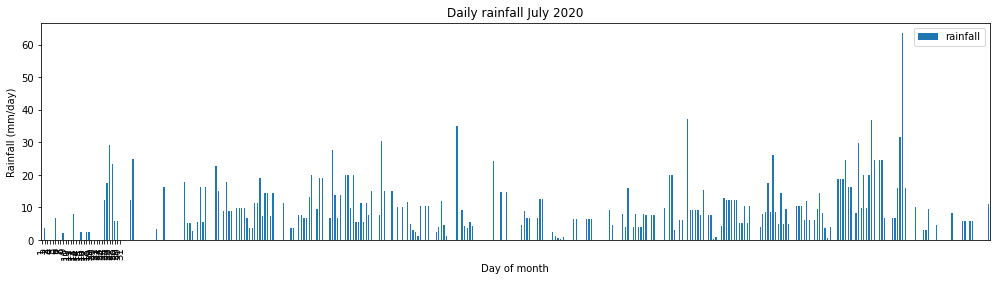

In [5]:
# Plot data fro the year
ds_rf_daily_mean.plot.bar(figsize=(17,4))
plt.title('Daily rainfall July 2020')
plt.ylabel('Rainfall (mm/day)')
plt.xlabel('Day of month')
plt.xticks(np.arange(0,31,1), np.arange(1,32,1));

In [6]:
# Get summary for the year as well as LR and SR season
station = 'chwele'
ds = ds_rf_daily_mean.copy()
rainy_days, monthly  = yearly_summary(ds)

rainy_days['LR'] = rainy_days['date'].apply(lambda x: x.month>= 3 and x.month<= 5)
rainy_days['SR'] = rainy_days['date'].apply(lambda x: x.month>= 10 and x.month<= 12)

print("In the year, there were {} days out of {} with more than 2mm of rain at {}".format(rainy_days['rain'].sum(), len(rainy_days), station)) 
print("In the Long Rain season (MAM), there were {} days out of {} with more than 2mm of rain at {}".format(rainy_days.query('LR ==True')['rain'].sum(), len(rainy_days.query('LR ==True')), station)) 
print("In the Short Rain season (OND), there were {} days out of {} with more than 2mm of rain at {}".format(rainy_days.query('SR ==True')['rain'].sum(), len(rainy_days.query('SR ==True')), station))

In the year, there were 211 days out of 366 with more than 2mm of rain at chwele
In the Long Rain season (MAM), there were 66 days out of 92 with more than 2mm of rain at chwele
In the Short Rain season (OND), there were 58 days out of 92 with more than 2mm of rain at chwele


In [7]:
#Summarize seasonal data
df_summ = get_seasonal_stats(rainy_days)
df_summ

,Variable,Annual,Long Rain,Short Rain
0,Rainfall amount,2352.090088,753.890015,762.890015
1,Rainy days with >2 mm,211.000000,66.000000,58.000000
2,Average Weekly rainfall (mm),44.000000,54.000000,54.000000
3,Number of weeks >10 mm,47.000000,13.000000,12.000000


#### Barchart of Monthly Rainy Cycles

Text(0.5, 1.0, 'Wet or Dry Days in chwele')

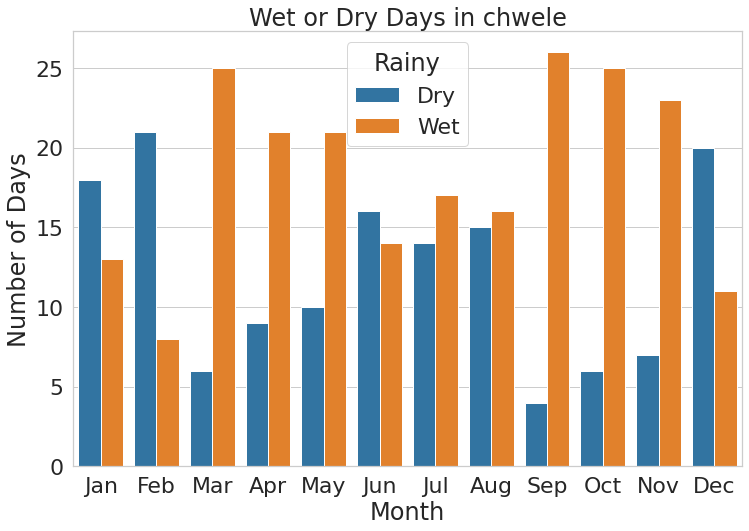

In [8]:
# Monthly plot of rainy days
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2)
sns.barplot(x="month_name", y="Days", hue="Rainy", data=monthly.sort_values(['month', 'Rainy']))
plt.xlabel("Month")
plt.ylabel("Number of Days")
plt.title("Wet or Dry Days in {}".format(station))

### Rainfall heatmap

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


Text(0.5, 1.0, 'Total Rainfall Daily')

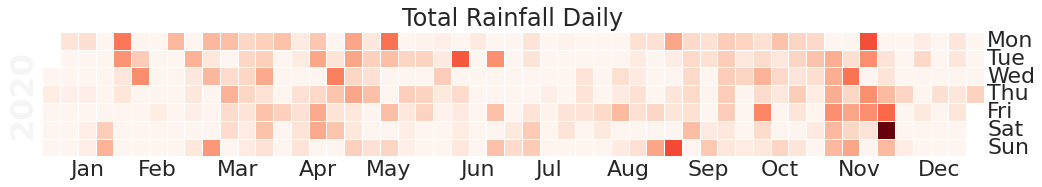

In [9]:
temp = rainy_days.copy().set_index(pd.DatetimeIndex(rainy_days['date']))
#temp.set_index('date', inplace=True)
fig, ax = calmap.calendarplot(temp['rain_amount'], fig_kws={"figsize":(15,4)})
plt.title("Total Rainfall Daily")